# Confidence Interval Simulation

This notebook works through a simulation on confidence intervals, letting us see firsthand where the randomness is coming from. 

## Preamble

First we load some useful packages and set the seed for our random number generator (this chooses a starting point, allowing us all to get the same simulation results). 

In [97]:
set.seed(3482) # setting the seed lets us start from the same "random" place every time when generating variables
library(tidyverse)

## Simulating A Population of size N = 100,000

We'll start by generating our population of interest, where our variable $X$ is distributed normally with a population mean $\mu$ of 4 and a variance $\sigma^2$ of 4 (SD of 2): $X \sim N(4,4)$. 

Let's start with a population that has 100,000 observations.

In [98]:
pop <- data.frame(x = rnorm(100000, mean = 4, sd = 2))
head(pop)

,x
,<dbl>
1,2.2958837
2,3.2076796
3,8.1069590
4,1.7989541
5,4.6109214
6,0.3471974


## Confidence Interval for a Sample of size n = 50

Here we begin by taking a sample of size 50 for $X$ and then construct a confidence interval. Since we generated this variable, we know with certainty what the population parameter values are. However, in ordinary circumstances, we don't get to observe $\mu$ directly, so we want to use the sample to construct a confidence interval and get a range of likely values for $\mu$.

We can use the very convenient `slice_sample()` function in tidyverse to do this. The first argument is the name of our dataframe, and the second is the number of observations we want to randomly sample (here $n=50$). 

In [99]:
# One sample CI
n <- 50
# sample of 50 obs drawn from an N(4,4) distribution
sample_50 <- slice_sample(pop, n = 50)

# get the mean and sample standard deviation
m <- mean(sample_50$x)
s <- sd(sample_50$x)

# draw the critical value from a t dist with df = 50-1=49
c <- qt(0.975, 49)
# Calculate lower and upper bounds for a 95% confidence interval
# recall the 
ci_low <- m - c*s/sqrt(n)
ci_upper <- m + c*s/sqrt(n) 

one_sim <- data.frame(Mean = m,
                  Standard.Deviation = s,
                  CI_Lower = ci_low,
                  CI_Upper = ci_upper)
one_sim

Mean,Standard.Deviation,CI_Lower,CI_Upper
<dbl>,<dbl>,<dbl>,<dbl>
3.602531,2.093004,3.007706,4.197357


We can see that our 95% confidence interval is [3.01, 4.20], which does cover the true mean $\mu=4$! 

## Simulating 1,000 samples of size n = 50

While our first sample and confidence interval managed to cover the true mean, what happens if we do this a *lot* of times?

To explore this, let's first build a function that draws a single sample of size $n$ and constructs a 95\% confidence interval. To do this we can mostly just pilfer the code we used above.

In [100]:
## Function to draw a sample of size n, construct 95% CI
# argument 1: the sample size, ss
# argument 2: the population data frame, df
samp_ci = function(ss, df){
    # draw sample of size n from the population data
    s <- slice_sample(df, n = ss)
    # construct CI
    m <- mean(s$x)
    s <- sd(s$x)
    c <- qt(0.975, 49)
    
    # put together output dataframe
    res <- data.frame(Mean = m,
                  Standard.Deviation = s,
                  CI_Lower =  m - c*s/sqrt(ss),
                  CI_Upper = m + c*s/sqrt(ss) )
    # tell the function what to return as output
    return(res)
}


What we did here is write a function that has two arguments. First, we tell R the sample size we want to use ($ss$). Second, we tell the function what the population data is called ($df$). 

Let's test it by drawing a sample of size $n=50$ and letting our function know that our population data is stored in **pop**

In [101]:
samp_ci(ss=50, df=pop)

Mean,Standard.Deviation,CI_Lower,CI_Upper
<dbl>,<dbl>,<dbl>,<dbl>
3.68156,1.976411,3.11987,4.24325


And we can see that we once again obtained a 95\% confidence interval that covers the true mean $\mu=4$.

Now let's go ahead and see what happens if we draw 1,000 samples and calculate confidence intervals for each one. To do this we can use the `map_dfr()` function:

In [102]:
# run samp_ci 1000 times, each time using a sample size of 50
ci_1k <- map_dfr(rep_len(50, 1000), samp_ci, df = pop)
head(rep_len(50, 1000))
head(ci_1k, 20)

[1] 50 50 50 50 50 50

,Mean,Standard.Deviation,CI_Lower,CI_Upper
,<dbl>,<dbl>,<dbl>,<dbl>
1,3.910787,1.986493,3.346232,4.475342
2,4.038107,2.346277,3.371303,4.704912
3,4.441606,2.049776,3.859067,5.024146
4,3.840045,2.090529,3.245924,4.434167
5,3.481528,2.221027,2.850319,4.112737
6,4.468832,1.958048,3.912361,5.025303
7,4.348770,2.112055,3.748531,4.949010
8,4.215372,1.861171,3.686433,4.744311
9,4.608827,2.126813,4.004393,5.213261


What kind of sorcery did we just pull? First, let's walk through how the function works. `map_dfr()` is part of **dplyr** in **tidyverse** and allows us to apply a function to every element in a vector. In this case, we used the vector `rep_len(50, 1000)` - which is just the value 50 repeated over and over again 1000 times -  as the first argument. Our second argument is the name of the function we want to loop over - here our `samp_ci()` we built. Finally, since `samp_ci()` has an additional argument (the population dataframe name), we have to pass it in as a third argument (the `df = pop` part). `map_dfr()` then row binds together the output of all 1000 runs of our confidence interval function, resulting in a new dataframe with 1000 rows where each row contains the sample mean, std deviation, and confidence interval bounds for each sample.

## Failures of our Confidence Intervals

Now let's check to see how many of these confidence intervals __do not__ include our true population mean, $\mu = 4$. We'll do this by creating dummy variables that are equal to one if the lower bound is greater than 4, or if the upper bound is less than 4. 

To get a sense of how often the confidence interval doesn't contain the true mean of 4, we can sum up the positive values for our $bad_lower$ and $bad_upper$ variables and divide by the number of simulations.

In [103]:
# Add variables indicating whether or not a confidence interval's lower bound is above 4 
# or if the upper bound is below 4 (i.e. CI doesn't include true mean)
ci_1k <- mutate(ci_1k,
                bad_lower = ifelse(CI_Lower > 4, 1, 0),
                bad_upper = ifelse(CI_Upper < 4, 1, 0))
head(ci_1k, 10)
tail(ci_1k, 10)

# Percentage of simulations with confidence intervals that don't include the true mean
bad_frac <- (sum(ci_1k$bad_lower) + sum(ci_1k$bad_upper))/ 1000
paste0("The fraction of 95% confidence intervals that do not include the true mean of 4 is ", bad_frac)

,Mean,Standard.Deviation,CI_Lower,CI_Upper,bad_lower,bad_upper
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3.910787,1.986493,3.346232,4.475342,0,0
2,4.038107,2.346277,3.371303,4.704912,0,0
3,4.441606,2.049776,3.859067,5.024146,0,0
4,3.840045,2.090529,3.245924,4.434167,0,0
5,3.481528,2.221027,2.850319,4.112737,0,0
6,4.468832,1.958048,3.912361,5.025303,0,0
7,4.348770,2.112055,3.748531,4.949010,0,0
8,4.215372,1.861171,3.686433,4.744311,0,0
9,4.608827,2.126813,4.004393,5.213261,1,0


,Mean,Standard.Deviation,CI_Lower,CI_Upper,bad_lower,bad_upper
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
991,4.277897,2.122407,3.674716,4.881079,0,0
992,4.089050,1.962988,3.531175,4.646925,0,0
993,3.705451,1.984583,3.141439,4.269464,0,0
994,3.885479,1.879134,3.351435,4.419523,0,0
995,3.644927,1.606857,3.188264,4.101591,0,0
996,4.155491,2.170413,3.538667,4.772316,0,0
997,4.448039,1.812853,3.932832,4.963246,0,0
998,3.997748,1.832535,3.476948,4.518549,0,0
999,4.294005,1.647902,3.825676,4.762333,0,0


[1] "The fraction of 95% confidence intervals that do not include the true mean of 4 is 0.048"

 Looking at the first ten and last ten samples, we see only one out of twenty missed high. In fact, we see that the 95% confidence intervals for our simulations do not contain the true population mean in 4.8\% of the samples, almost exactly equal to 5%!

## Plotting the Distribution of $\bar{X}$

The below plot shows our distribution for $\bar{X}$. The red lines represent the upper and lower bounds for a 95% confidence interval using the true _population_ standard deviation. Since we generated our samples from an $N(4,4)$ distribution, we know that $\sigma = 2$ and can calculate the confidence interval as

$$ \text{95% True Confidence Interval} ~=~ \left[\bar{x} - 1.96 \cdot \frac{\sigma}{\sqrt{n}},~ \bar{x} + 1.96 \cdot \frac{\sigma}{\sqrt{n}}\right]$$

$$ \text{95% True Confidence Interval} ~=~ \left[\bar{x} - 1.96 \cdot \frac{2}{\sqrt{50}},~ \bar{x} + 1.96 \cdot \frac{2}{\sqrt{50}}\right]$$

$$ \text{95% True Confidence Interval} ~=~ \left[3.4456, 4.5544 \right]$$

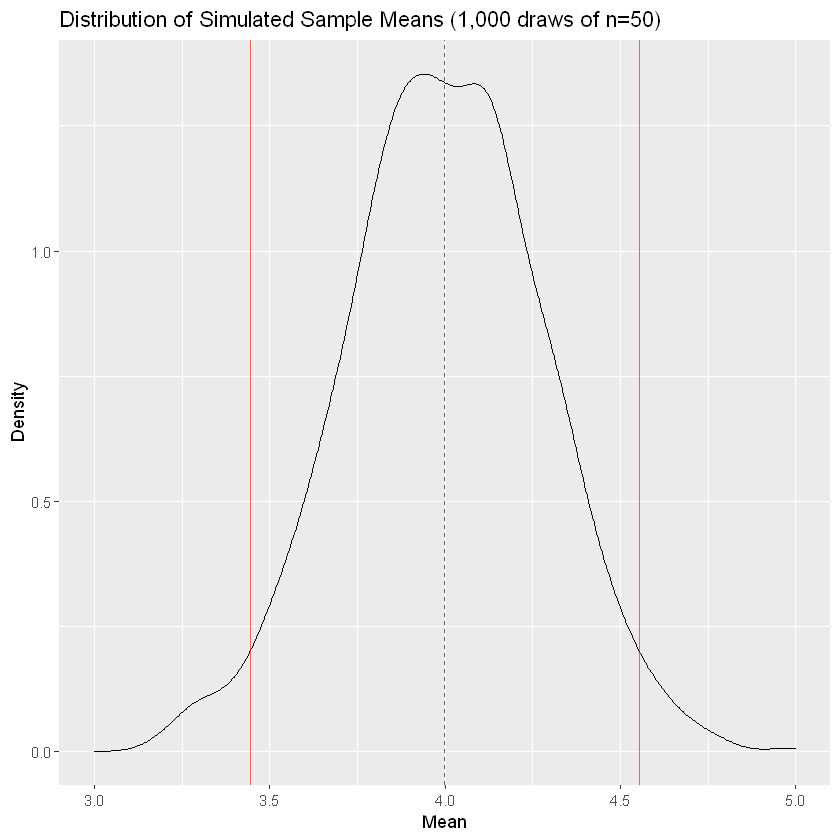

In [104]:
true_lower <- 4-1.96*2/sqrt(n)
true_upper <- 4+1.96*2/sqrt(n)

ggplot(ci_1k, aes(x=Mean)) +
  geom_density() +
    lims(x = c(3,5)) +
  geom_vline(xintercept = true_lower, colour = "red", alpha = 0.6) +
  geom_vline(xintercept = mean(ci_1k$Mean), linetype = "dashed", alpha = 0.6) +
  geom_vline(xintercept = true_upper, colour = "red", alpha = 0.6) + 
  labs( title = "Distribution of Simulated Sample Means (1,000 draws of n=50)",
        x = "Mean",
        y = "Density")

And we see three things:
1. Our distribution looks very similar to a normal distribution. If we took more draws or increased our sample size, it would likely smooth out even more.
2. The distribution is centered around the true mean $\mu = 4$
3. It seems like a reasonable guess that roughly 0.025 of the distribution's area fall beyond the lower and upper confidence interval lines in each tail.

## Plotting the Simulated Confidence Intervals

Another thing we expect due to the symmetry of the normal distribution is that our confidence interval failures should be symmetric. That is, $bad\_lower$ and $bad\_upper$ should be about equal in number.

Another way to evaluate this is by plotting the lower versus upper limits and comparing their shape to the horizontal and vertical lines at $\mu =4$. We would like to see a scatterplot that is symmetric around the 45 degree line through the point $(4,4)$.

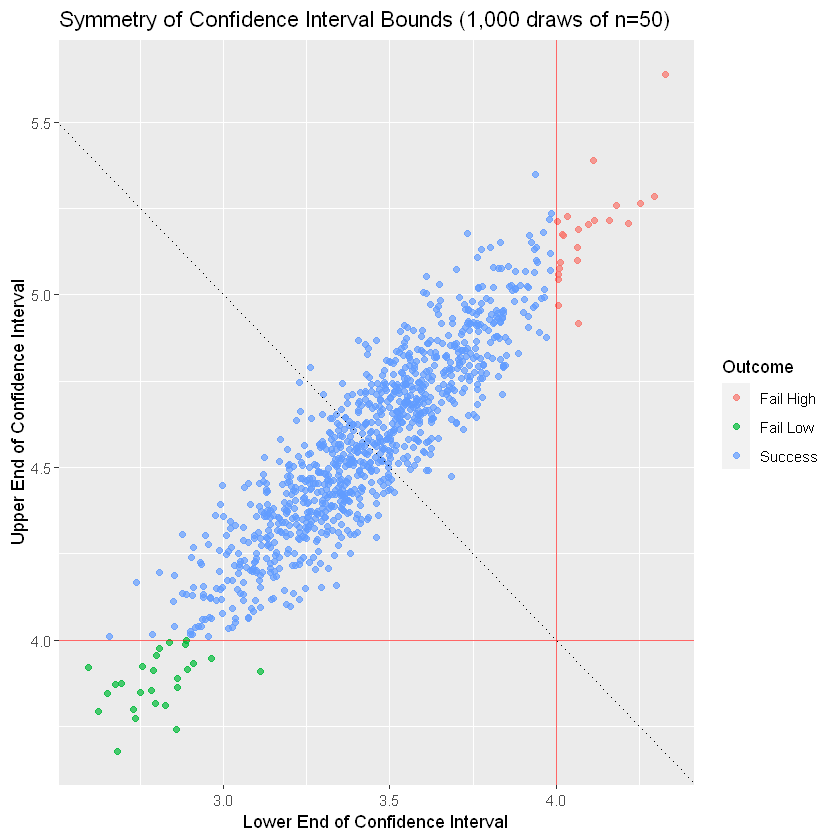

In [105]:
mutate(ci_1k, Outcome = case_when(
                         bad_lower == 1 ~ "Fail High",
                         bad_upper == 1 ~ "Fail Low",
                         TRUE ~ "Success")) %>%
ggplot() +
geom_point(aes(x = CI_Lower, y = CI_Upper, color = Outcome), alpha = 0.7) +
geom_abline(intercept = 8, slope = -1, linetype = "dotted") + 
geom_hline(yintercept = 4, colour = "red", alpha = 0.6) +
geom_vline(xintercept = 4, colour = "red", alpha = 0.6) +
labs(x = "Lower End of Confidence Interval",
    y = "Upper End of Confidence Interval",
    title = "Symmetry of Confidence Interval Bounds (1,000 draws of n=50)")




And we see exactly that! The distribution of points above/right of the 45 degree line looks to be just about identical as the shape below/left. We can also see the cases where we "Failed high" in red (lower limit above 4) and "Failed Low" in green (upper limit below 4) occur in similar frequencies and combined represent 5\% of samples.

And for those wondering: `case_when()` is basically a decision tree version of `ifelse()`. As we've written it, R starts by checking whether the *bad_lower* variable equals 1, in which case it assigns the value "Fail High" to the new variable *Outcome*. If *bad_lower* is zero, then we proceed to the next case. If `bad_upper` is one, we assign "Fail Low". Finally, if we don't match either of our two cases (i.e. *TRUE* reflects anything that makes it to the bottom of the tree), then we assign the value "Success". 

If you're familiar with SQL, this is the R version of `CASE WHEN`.

## What Happens When We Increase the Sample Size?

Previously all our samples were of size $n=50$. What if we instead took samples of size $n' = 500$?

In [106]:
nprime <- 500
# draw 1000 confidence intervals for sample size of 500
ci_500 <- map_dfr(rep_len(500, 1000), samp_ci, df = pop)
head(ci_500, 10)
tail(ci_500, 10)


,Mean,Standard.Deviation,CI_Lower,CI_Upper
,<dbl>,<dbl>,<dbl>,<dbl>
1,3.931452,2.002461,3.751489,4.111416
2,4.173798,1.874562,4.005330,4.342267
3,4.024387,1.963490,3.847926,4.200847
4,4.013690,1.957715,3.837749,4.189632
5,3.835529,2.030542,3.653042,4.018015
6,3.887628,1.990231,3.708764,4.066492
7,4.057659,1.997909,3.878105,4.237213
8,4.055592,1.994431,3.876351,4.234834
9,3.978306,2.016436,3.797087,4.159525


,Mean,Standard.Deviation,CI_Lower,CI_Upper
,<dbl>,<dbl>,<dbl>,<dbl>
991,3.963283,1.986051,3.784794,4.141771
992,4.029954,2.077283,3.843266,4.216641
993,4.048748,2.082544,3.861588,4.235908
994,3.826067,1.873439,3.657699,3.994435
995,4.100915,1.968199,3.924031,4.277799
996,3.934183,1.961589,3.757893,4.110473
997,3.923376,1.907969,3.751905,4.094847
998,3.946130,1.921803,3.773416,4.118844
999,3.994839,2.049273,3.810669,4.179009


First off, we can see that the sample means and standard deviations are much more tightly clustered around the true population mean (4) and standard deviation (2). As a result, our 95% confidence intervals are also much tighter around the true mean.

In [107]:
ci_500 <- mutate(ci_500, bad_lower = (4 < CI_Lower),
           bad_upper = (CI_Upper < 4))

bad_frac_prime <- (sum(ci_500$bad_lower) + sum(ci_500$bad_upper))/ 1000
paste0("The fraction of 95% confidence intervals that do not include the true mean of 4 is ", bad_frac_prime)

[1] "The fraction of 95% confidence intervals that do not include the true mean of 4 is 0.038"

And once again we have about 5% of the (now much narrower) confidence intervals not including the true mean $\mu =4$.

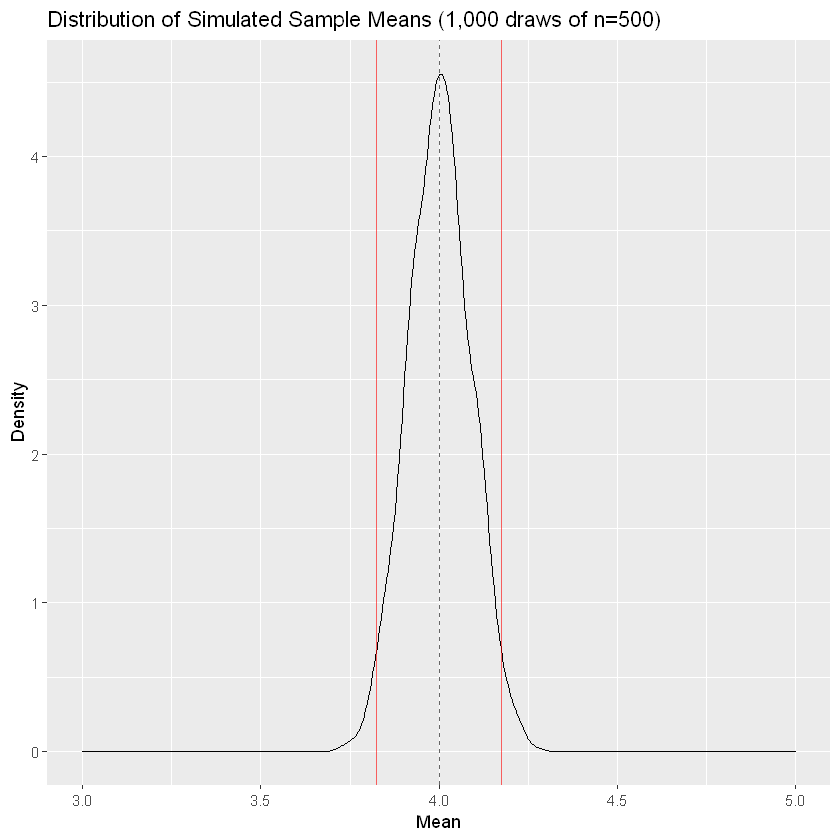

In [108]:
true_low_prime <- 4-1.96*2/sqrt(nprime)
true_upper_prime <- 4+1.96*2/sqrt(nprime)

ggplot(ci_500, aes(x = Mean)) +
  geom_density() +
lims(x = c(3,5)) +
  geom_vline(xintercept = mean(ci_500$Mean), linetype = "dashed", alpha = 0.6) +
  geom_vline(xintercept = true_low_prime, colour = "red", alpha = 0.6) +
  geom_vline(xintercept = true_upper_prime, colour = "red", alpha = 0.6) + 
  labs( title = "Distribution of Simulated Sample Means (1,000 draws of n=500)",
        x = "Mean",
        y = "Density")

Our distribution now looks even more like a normal distribution, and is much smoother overall. Notice especially how it is also *much* more tightly concentrated around the true population mean!

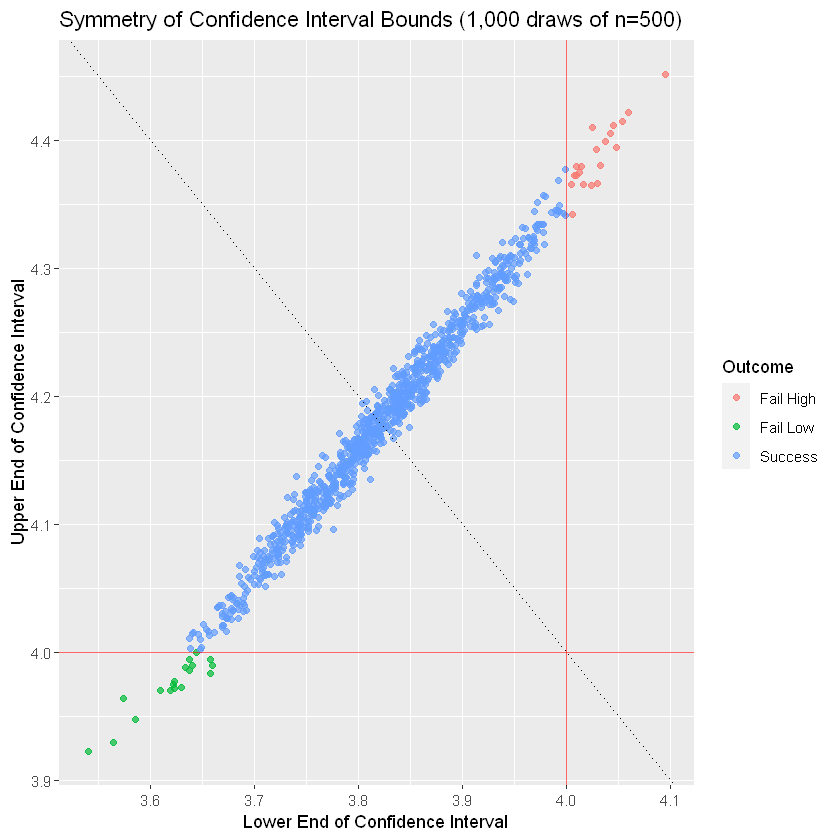

In [109]:
mutate(ci_500, Outcome = case_when(
                         bad_lower == 1 ~ "Fail High",
                         bad_upper == 1 ~ "Fail Low",
                         TRUE ~ "Success")) %>%
ggplot() +
geom_point(aes(x = CI_Lower, y = CI_Upper, color = Outcome), alpha = 0.7) +
geom_abline(intercept = 8, slope = -1, linetype = "dotted") + 
geom_hline(yintercept = 4, colour = "red", alpha = 0.6) +
geom_vline(xintercept = 4, colour = "red", alpha = 0.6) +
labs(x = "Lower End of Confidence Interval",
    y = "Upper End of Confidence Interval",
    title = "Symmetry of Confidence Interval Bounds (1,000 draws of n=500)")


Now we can see that there is overall much less spread between the upper and lower confidence intervals for a given sample due to the lower standard errors, with still roughly 5% that don't fall into the first quadrant (i.e. contain the true population mean).